In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix

# Custom Focal Loss implementation (if external package is unavailable)
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        
    def forward(self, inputs, targets):
        # Compute standard cross entropy loss (without reduction)
        ce_loss = nn.functional.cross_entropy(inputs, targets, reduction='none')
        # Get pt: probability of the true class (using log-softmax trick)
        pt = torch.exp(-ce_loss)
        # Compute focal loss
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

print("✅ Libraries imported and custom FocalLoss defined.")


✅ Libraries imported and custom FocalLoss defined.


In [14]:
import os

# Update folder names to match your extracted dataset
ai_folder = os.path.join(dataset_path, "AiArtData/AiArtData")
real_folder = os.path.join(dataset_path, "RealArt")

# List the files in each folder to see what's inside
ai_files = os.listdir(ai_folder)
real_files = os.listdir(real_folder)

print(f"Number of AI-generated images (AiArtData): {len(ai_files)}")
print(f"Number of Real images (RealArt): {len(real_files)}")

# Optionally, print file names to verify
print("AI-generated image files:", ai_files)
print("Real image files:", real_files)


Number of AI-generated images (AiArtData): 539
Number of Real images (RealArt): 436
AI-generated image files: ['-how-important-people-from-the-past-really-looked-11-Pics-5ffd5c0f4d77f__880.jpg', '-s-fluffy-fur-and-round-features-immediately-melted-the-viewer-s-heart-photo.jpg', '-using-generative-ai-technology-landscape-pattern-abstract-concept-269270897.jpg', '-yellow-kimono-with-a-golden-crown-and-a-very-detailed-Barn-owl-copy-800x800.jpg', '.amazonaws.com2Fpublic2Fimages2Ff89de3bb-279b-42c9-9822-a653fb5b21e6_600x480.png', '0002_AI-in-animal-classification.png', '00urban_biodiversity_landscape_architecture_14ed209d-45ca-4c57-b995-4d1552813cc1.jpg', '03a3gbCKfH8dDJnjhHLuHDf-1.fit_lim.v1665523315.png', '06as5rHi0sgG4W2Tq.png', '06db055c-ai-hallucination-rag-1024x688.jpg', '07-the-coffee-service-hossaini-art-ai.x3e656121.png', '07IHO-LENSA-TOPART-articleLarge.jpg', '082922_GeneratedArtAI_02_teh_z1b_04.jpg', '08_No-more-lost-in-translation.jpg', '0EAwg7WIIMhgnSfLf.png', '0nglsAEPlxapCcJZ

In [15]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split

# Define transformations for training and validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

# Create dataset using ImageFolder; 
# ImageFolder automatically assigns labels based on folder names.
dataset = datasets.ImageFolder(dataset_path, transform=data_transforms['train'])

# Print the class-to-index mapping to verify folder names
print("Class to index mapping:", dataset.class_to_idx)
# For example, it might output: {'AiArtData': 0, 'RealArt': 1}

# Split dataset into 80% training and 20% validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Update the validation dataset's transform to use the validation transforms
val_dataset.dataset.transform = data_transforms['val']

# Create DataLoaders for both training and validation sets
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")


Class to index mapping: {'AiArtData': 0, 'RealArt': 1}
Training samples: 778, Validation samples: 195


In [16]:
import torch
import torch.nn as nn
import torchvision.models as models

# Set device for training (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load ConvNeXt-Tiny pretrained model
model = models.convnext_tiny(pretrained=True)

# Modify the classifier to output 2 classes
# ConvNeXt-Tiny's classifier is a Sequential module. Replace the last layer.
num_features = model.classifier[2].in_features
model.classifier[2] = nn.Linear(num_features, 2)  # 2 classes: AI-Generated (0) and Real (1)

# Move model to the device
model = model.to(device)

print("✅ ConvNeXt-Tiny model loaded and modified for binary classification!")


c:\Users\anush\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\anush\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to C:\Users\anush/.cache\torch\hub\checkpoints\convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:48<00:00, 2.38MB/s] 


✅ ConvNeXt-Tiny model loaded and modified for binary classification!


In [17]:
import torch
import torch.nn as nn
import torchvision.models as models

# Set device for training (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load ConvNeXt-Tiny pretrained model
model = models.convnext_tiny(pretrained=True)

# Modify the classifier to output 2 classes
# ConvNeXt-Tiny's classifier is a Sequential module. Replace the last layer.
num_features = model.classifier[2].in_features
model.classifier[2] = nn.Linear(num_features, 2)  # 2 classes: AI-Generated (0) and Real (1)

# Move model to the device
model = model.to(device)

print("✅ ConvNeXt-Tiny model loaded and modified for binary classification!")


✅ ConvNeXt-Tiny model loaded and modified for binary classification!


In [ ]:
import torch.optim as optim

# Define loss function using the custom FocalLoss
criterion = FocalLoss(alpha=0.25, gamma=2)

# Define optimizer (Adam) and learning rate scheduler
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

print("✅ Loss function, optimizer, and scheduler defined!")


✅ Loss function, optimizer, and scheduler defined!


In [24]:
num_epochs = 10
best_val_acc = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct_preds += torch.sum(preds == labels.data)
    
    # Update learning rate
    scheduler.step()
    
    epoch_loss = running_loss / train_size
    epoch_acc = correct_preds.double() / train_size
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.4f}")
    
    # Validation phase
    model.eval()
    val_correct = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            val_correct += torch.sum(preds == labels.data)
    
    val_acc = val_correct.double() / val_size
    print(f"Validation Accuracy: {val_acc:.4f}")
    
    # Save the best model based on validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print("✅ Best model saved!")
        
print("✅ Training complete. Best validation accuracy:", best_val_acc)


Epoch 1/10 - Loss: 0.0346, Training Accuracy: 0.7237
Validation Accuracy: 0.7949
✅ Best model saved!
Epoch 2/10 - Loss: 0.0098, Training Accuracy: 0.9524
Validation Accuracy: 0.8359
✅ Best model saved!
Epoch 3/10 - Loss: 0.0034, Training Accuracy: 0.9884
Validation Accuracy: 0.8256
Epoch 4/10 - Loss: 0.0013, Training Accuracy: 0.9949
Validation Accuracy: 0.8205
Epoch 5/10 - Loss: 0.0007, Training Accuracy: 1.0000
Validation Accuracy: 0.8308
Epoch 6/10 - Loss: 0.0004, Training Accuracy: 1.0000
Validation Accuracy: 0.8410
✅ Best model saved!
Epoch 7/10 - Loss: 0.0005, Training Accuracy: 1.0000
Validation Accuracy: 0.8513
✅ Best model saved!
Epoch 8/10 - Loss: 0.0005, Training Accuracy: 1.0000
Validation Accuracy: 0.8359
Epoch 9/10 - Loss: 0.0006, Training Accuracy: 0.9974
Validation Accuracy: 0.8462
Epoch 10/10 - Loss: 0.0004, Training Accuracy: 1.0000
Validation Accuracy: 0.8513
✅ Training complete. Best validation accuracy: tensor(0.8513, dtype=torch.float64)


In [25]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Real", "AI-Generated"]))
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


Classification Report:
              precision    recall  f1-score   support

        Real       0.82      0.90      0.86        98
AI-Generated       0.89      0.80      0.84        97

    accuracy                           0.85       195
   macro avg       0.85      0.85      0.85       195
weighted avg       0.85      0.85      0.85       195

Confusion Matrix:
[[88 10]
 [19 78]]


In [26]:
# Save the best model (this was already done during training but this ensures it's saved)
torch.save(model.state_dict(), "best_model.pth")
print("✅ Model saved as 'best_model.pth'")

# Optional: Uncomment the lines below if you want to download the model when using Google Colab
# from google.colab import files
# files.download("best_model.pth")


✅ Model saved as 'best_model.pth'


Raw probabilities: [0.7055491  0.29445082]
Predicted: AI-Generated (Confidence: 0.71)


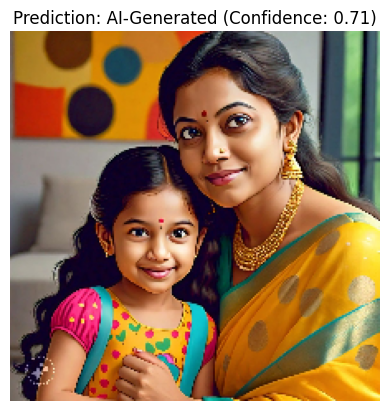

In [42]:
import numpy as np
import torch.nn.functional as F
import tensorflow as tf
import matplotlib.pyplot as plt

def predict_image(img_path, model, device):
    # Load and preprocess the image
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0  # Normalize to [0,1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    # Convert to PyTorch tensor: [B, H, W, C] -> [B, C, H, W]
    tensor_img = torch.tensor(img_array).permute(0, 3, 1, 2).float().to(device)
    
    model.eval()
    with torch.no_grad():
        outputs = model(tensor_img)
        probs = F.softmax(outputs, dim=1).cpu().numpy()[0]
    
    print("Raw probabilities:", probs)
    pred_class = np.argmax(probs)
    label = "Real" if pred_class == 1 else "AI-Generated"
    confidence = probs[pred_class]
    
    print(f"Predicted: {label} (Confidence: {confidence:.2f})")
    
    plt.imshow(img)
    plt.title(f"Prediction: {label} (Confidence: {confidence:.2f})")
    plt.axis("off")
    plt.show()

# Test on a new image:
test_img_path = "mom.jpg"  # Replace with your actual image path
predict_image(test_img_path, model, device)


In [34]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["AI-Generated", "Real"]))
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


Classification Report:
              precision    recall  f1-score   support

AI-Generated       0.82      0.90      0.86        98
        Real       0.89      0.80      0.84        97

    accuracy                           0.85       195
   macro avg       0.85      0.85      0.85       195
weighted avg       0.85      0.85      0.85       195

Confusion Matrix:
[[88 10]
 [19 78]]


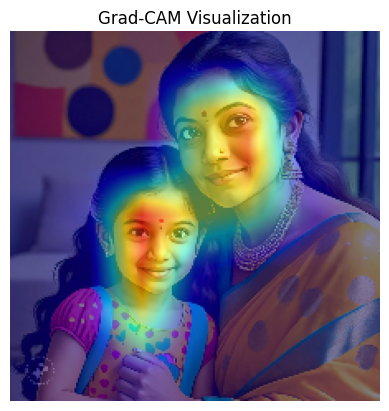

In [41]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
import cv2
import matplotlib.pyplot as plt

# Choose a target layer (for ConvNeXt-Tiny, the last convolutional layer is typically in model.features)
cam = GradCAM(model=model, target_layers=[model.features[-1]])

def visualize_gradcam(img_path, cam):
    # Read image using cv2 and convert to RGB
    img = cv2.imread(img_path)
    if img is None:
        print("Error: Image not found. Check your image path.")
        return
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (224, 224))
    
    # Preprocess image for Grad-CAM (using provided utility)
    input_tensor = preprocess_image(img_resized, mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225])
    # Compute Grad-CAM
    grayscale_cam = cam(input_tensor=input_tensor, aug_smooth=True, eigen_smooth=True)[0]
    visualization = show_cam_on_image(img_resized.astype(float)/255, grayscale_cam, use_rgb=True)
    
    plt.imshow(visualization)
    plt.title("Grad-CAM Visualization")
    plt.axis("off")
    plt.show()

# Test Grad-CAM on a sample image (update path accordingly)
sample_img_path = "mom.jpg"  # Replace with an actual image path
visualize_gradcam(sample_img_path, cam)
